# Intro:  Using Pseudo-labeling with Emotions Classifier

In this notebook, I will take the dataset that I already ran through the "j-hartmann/emotion-english-roberta-large" model so that it now has emotion labels. I will balance the data so the neutral class is not so dominant. Then I will split it into train/test/validate, and run it through the model again. This way I can see if the model is consistent in its classification.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.1 MB/s eta 0:00:00


In [2]:
!pip install transformers

In [3]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 3.5 MB/s eta 0:00:00


In [4]:
!pip install jsonlines

In [5]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00


In [6]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.7 MB/s eta 0:00:00


In [7]:
import torch
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cuda.


In [8]:
import accelerate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import evaluate
from datasets import load_dataset
from datasets import DatasetDict
import datasets
from torch.utils.data import DataLoader
import jsonlines
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score
import seaborn as sns
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


### Data Preprocessing

In [9]:
# import data that is already tokenized and labeled
data = datasets.load_from_disk("/content/drive/MyDrive/DATA 495/labeled_dataset")

In [10]:
# show data setup
data

Dataset({
    features: ['Unnamed: 0', 'Date', 'Title', 'Segmented_Transcript', 'input_ids', 'attention_mask', 'predicted_sentiment'],
    num_rows: 157037
})

In [11]:
# drop unnecessary columns
data = data.remove_columns(['Unnamed: 0', 'Date', "Title"])

In [12]:
# confirm it worked
data

Dataset({
    features: ['Segmented_Transcript', 'input_ids', 'attention_mask', 'predicted_sentiment'],
    num_rows: 157037
})

In [26]:
# convert data to dataframe
data.set_format(type='pandas')
df = data.to_pandas()


In [27]:
df.head()

,Segmented_Transcript,input_ids,attention_mask,predicted_sentiment
0,"Vladimir Putin: Dear friends, On New Year’s Ev...","[0, 846, 15356, 32850, 3176, 35, 12191, 964, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5
1,a minute. I promise you that any attempts to a...,"[0, 102, 2289, 4, 38, 4198, 47, 14, 143, 3881,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4
2,"own, the president acted in full compliance wi...","[0, 3355, 6, 5, 394, 8337, 11, 455, 6265, 19, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3
3,kindest and the most loved holiday in Russia....,"[0, 761, 990, 8, 5, 144, 2638, 2317, 11, 798, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",3
4,"Vladimir Putin: Good afternoon, distinguished ...","[0, 846, 15356, 32850, 3176, 35, 2497, 1390, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4


In [28]:
# balance data

from imblearn.under_sampling import RandomUnderSampler

# Assuming df is your DataFrame
# Display the original class distribution
print("Original Class Distribution:")
print(df['predicted_sentiment'].value_counts())

# Separate features and target variable
X = df.drop('predicted_sentiment', axis=1)
y = df['predicted_sentiment']

# Instantiate the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Undersample the majority class
X_resampled, y_resampled = rus.fit_resample(X, y)

# Create a new balanced DataFrame
df_balanced = pd.concat([X_resampled, y_resampled], axis=1)

# Display the balanced class distribution
print("\nBalanced Class Distribution:")
print(df_balanced['predicted_sentiment'].value_counts())

Original Class Distribution:
4    111117
3     25528
2      8716
0      4468
5      3686
1      1808
6      1714
Name: predicted_sentiment, dtype: int64

Balanced Class Distribution:
0    1714
1    1714
2    1714
3    1714
4    1714
5    1714
6    1714
Name: predicted_sentiment, dtype: int64


In [44]:
df_balanced['predicted_sentiment'].value_counts()

0    1714
1    1714
2    1714
3    1714
4    1714
5    1714
6    1714
Name: predicted_sentiment, dtype: int64

In [45]:
# save balanced df to csv
df_balanced.to_csv('/content/drive/MyDrive/DATA 495/bal_emotion_df.csv')

In [46]:
# import data as huggingface dataset
bal_emo_df =  load_dataset("csv", data_files='/content/drive/MyDrive/DATA 495/bal_emotion_df.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [47]:
bal_emo_data = bal_emo_df['train']

In [49]:
bal_emo_data

Dataset({
    features: ['Unnamed: 0', 'Segmented_Transcript', 'input_ids', 'attention_mask', 'predicted_sentiment'],
    num_rows: 11998
})

In [50]:
bal_emo_data = bal_emo_data.remove_columns(['Unnamed: 0'])

In [51]:
bal_emo_data

Dataset({
    features: ['Segmented_Transcript', 'input_ids', 'attention_mask', 'predicted_sentiment'],
    num_rows: 11998
})

In [52]:
# split into train/test/validate sets
# 90% train, 10% test + validation
train_testvalid = bal_emo_data.train_test_split(test_size=0.1)

In [53]:
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.3)

In [56]:

# gather everyone if you want to have a single DatasetDict
bal_data = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [57]:
# verify it looks right
bal_data

DatasetDict({
    train: Dataset({
        features: ['Segmented_Transcript', 'input_ids', 'attention_mask', 'predicted_sentiment'],
        num_rows: 10798
    })
    test: Dataset({
        features: ['Segmented_Transcript', 'input_ids', 'attention_mask', 'predicted_sentiment'],
        num_rows: 360
    })
    valid: Dataset({
        features: ['Segmented_Transcript', 'input_ids', 'attention_mask', 'predicted_sentiment'],
        num_rows: 840
    })
})

In [58]:
# save split dataset
split_balanced_data = bal_data.save_to_disk('/content/drive/MyDrive/DATA 495/split_balanced_data')

Saving the dataset (0/1 shards):   0%|          | 0/10798 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/360 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/840 [00:00<?, ? examples/s]

### Tokenize the dataset


In [59]:
# load tokenizer and model, create trainer
model_name = "j-hartmann/emotion-english-distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device_name)
trainer = Trainer(model=model)

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

In [63]:
bal_data = bal_data.rename_column("predicted_sentiment", "labels")

In [65]:
# class encode labels
bal_data = bal_data.class_encode_column("labels")

Stringifying the column:   0%|          | 0/10798 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/10798 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/360 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/360 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/840 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/840 [00:00<?, ? examples/s]

In [66]:
# Define a function to tokenize a specific column
def tokenize_column(batch):
    return tokenizer(batch['Segmented_Transcript'], padding=True, truncation=True)

In [67]:
# tokenize entire dataset
bal_data_tokenized = bal_data.map(tokenize_column, batched=True)

Map:   0%|          | 0/10798 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

In [68]:
bal_data_tokenized

DatasetDict({
    train: Dataset({
        features: ['Segmented_Transcript', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10798
    })
    test: Dataset({
        features: ['Segmented_Transcript', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 360
    })
    valid: Dataset({
        features: ['Segmented_Transcript', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 840
    })
})

## Fit the Model

In [76]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)

    # Convert NumPy arrays to lists
    precision = precision.tolist()
    recall = recall.tolist()
    f1 = f1.tolist()

    acc = accuracy_score(labels, preds)

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)

    # Convert the confusion matrix to a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3',
                                    'Actual 4', 'Actual 5', 'Actual 6'],
                         columns=['Predicted 0', 'Predicted 1', 'Predicted 2',
                                  'Predicted 3', 'Predicted 4', 'Predicted 5',
                                  'Predicted 6'])

    # Visualize the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [70]:
# log into hugging face hub
from huggingface_hub import notebook_login

notebook_login()

In [77]:
batch_size = 16
logging_steps = len(bal_data_tokenized['train']) // batch_size
model_name = "j-hartmann/emotion-english-distilroberta-base"
training_args = TrainingArguments( output_dir = model_name,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = "epoch",
                                  disable_tqdm = False,
                                  logging_steps = logging_steps,
                                  push_to_hub = True,
                                  log_level = "error"
                                   )

In [78]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=bal_data_tokenized['train'],
    eval_dataset=bal_data_tokenized['test'],
    tokenizer=tokenizer
)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.211600,0.538645,0.852778,"[0.792079207920792, 0.8932038834951458, 0.848, 0.875, 0.8333333333333333, 0.8131868131868132, 0.9130434782608695]","[0.8695652173913043, 0.8518518518518519, 0.7910447761194029, 0.8596491228070176, 0.9090909090909091, 0.8043478260869565, 0.9130434782608695]","[0.7272727272727273, 0.9387755102040817, 0.9137931034482759, 0.8909090909090909, 0.7692307692307693, 0.8222222222222222, 0.9130434782608695]"
2,0.208100,0.515962,0.855556,"[0.8269230769230769, 0.9019607843137256, 0.8421052631578947, 0.8888888888888888, 0.8200000000000001, 0.8041237113402062, 0.9052631578947369]","[0.8775510204081632, 0.8679245283018868, 0.8571428571428571, 0.9056603773584906, 0.8541666666666666, 0.75, 0.8775510204081632]","[0.7818181818181819, 0.9387755102040817, 0.8275862068965517, 0.8727272727272727, 0.7884615384615384, 0.8666666666666667, 0.9347826086956522]"


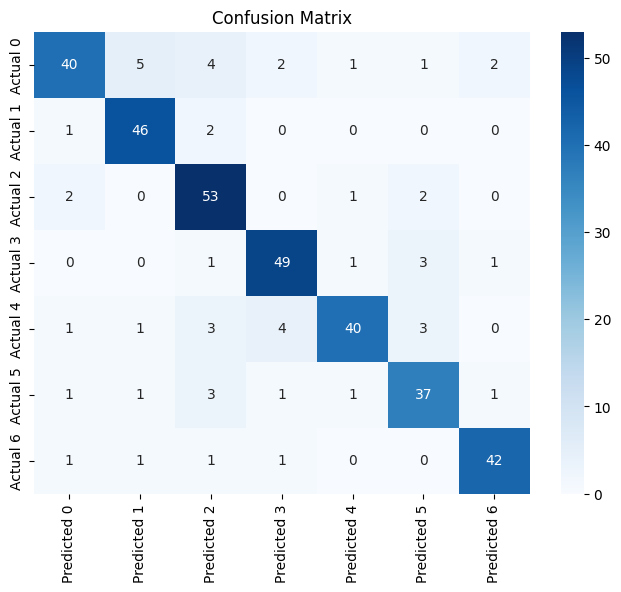

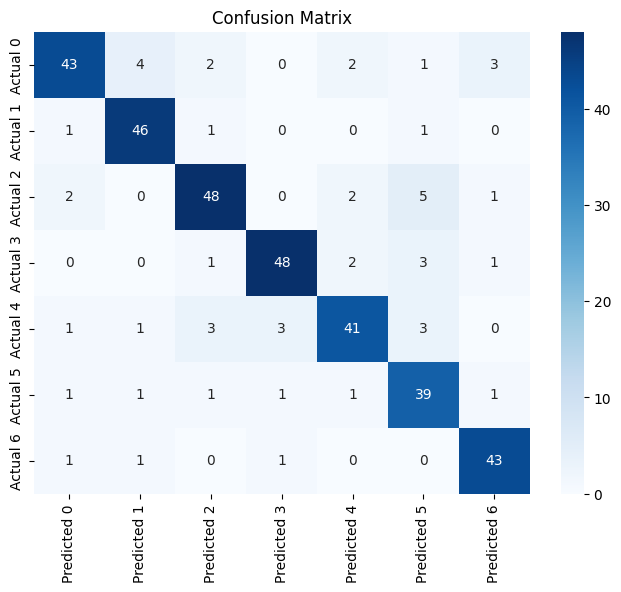

TrainOutput(global_step=1350, training_loss=0.2099616621158741, metrics={'train_runtime': 132.1663, 'train_samples_per_second': 163.4, 'train_steps_per_second': 10.214, 'total_flos': 877105522928400.0, 'train_loss': 0.2099616621158741, 'epoch': 2.0})

In [79]:
trainer.train()

## Evaluate the Model on Validate Data

In [80]:
# update dataset
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=bal_data_tokenized['train'],
    eval_dataset=bal_data_tokenized['valid'],
    tokenizer=tokenizer
)

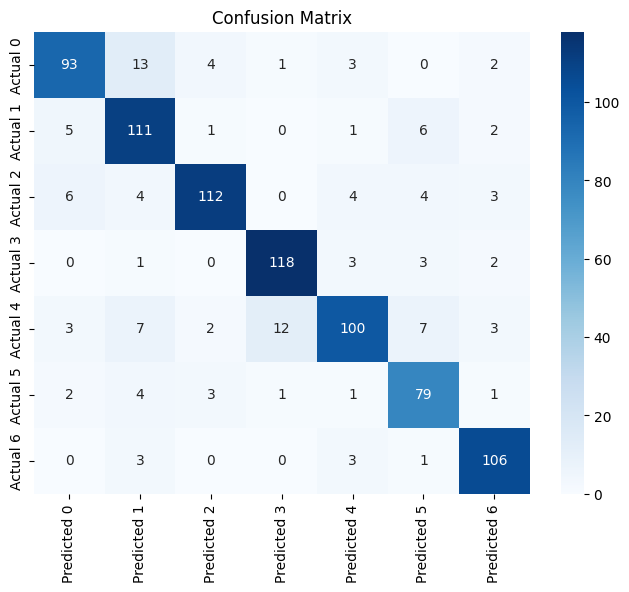

{'eval_loss': 0.5010406970977783,
 'eval_accuracy': 0.8559523809523809,
 'eval_f1': [0.8266666666666667,
  0.8252788104089219,
  0.8784313725490196,
  0.9111969111969113,
  0.8032128514056226,
  0.8272251308900523,
  0.9137931034482759],
 'eval_precision': [0.8532110091743119,
  0.7762237762237763,
  0.9180327868852459,
  0.8939393939393939,
  0.8695652173913043,
  0.79,
  0.8907563025210085],
 'eval_recall': [0.8017241379310345,
  0.8809523809523809,
  0.8421052631578947,
  0.9291338582677166,
  0.746268656716418,
  0.8681318681318682,
  0.9380530973451328],
 'eval_runtime': 2.3219,
 'eval_samples_per_second': 361.775,
 'eval_steps_per_second': 22.826}

In [81]:
trainer.evaluate()

In [84]:
# save model
trainer.save_model("/content/drive/MyDrive/DATA 495/emotion_classification")

## Tune the Hyperparameters


In [85]:
# import model we just trained and saved
model_checkpoint = "/content/drive/MyDrive/DATA 495/emotion_classification"


In [86]:
# define function to reinitialize model for each pass through
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=7)

In [87]:
# define the metric we're looking to optimize (accuracy)

def compute_single_metric(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate accuracy
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc}


In [88]:
# convert it to optuna single metric
def objective(metrics):
    return metrics['accuracy']

In [89]:
# redefine training arguments
batch_size = 4
logging_steps = 1000
args = TrainingArguments( output_dir = model_name,
                                  num_train_epochs = 4,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = "epoch",
                                  metric_for_best_model='accuracy',
                                  disable_tqdm = False,
                                  logging_steps = logging_steps,
                                  push_to_hub = True,
                                  log_level = "error"
                                   )

In [90]:
# define Trainer function

trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=bal_data_tokenized['train'],
    eval_dataset=bal_data_tokenized['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_single_metric
)

In [91]:
# reduce size of train dataset to fit memory better
train_dataset = bal_data_tokenized["train"].shard(index=1, num_shards=10)

In [92]:
# optuna training function

best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")


[I 2023-11-25 00:25:10,917] A new study created in memory with name: no-name-ae8e6338-a10c-4ccc-b7e0-eb2fcf295ced


Epoch,Training Loss,Validation Loss,Accuracy
1,0.169400,0.691068,0.863889
2,0.130700,0.714006,0.850000
3,0.129600,0.763644,0.847222
4,0.108600,0.790131,0.852778
5,0.096700,0.793694,0.855556


[I 2023-11-25 00:41:44,956] Trial 0 finished with value: 0.8555555555555555 and parameters: {'learning_rate': 1.9038155786431695e-06, 'num_train_epochs': 5, 'seed': 37, 'per_device_train_batch_size': 4}. Best is trial 0 with value: 0.8555555555555555.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.508153,0.861111
2,No log,0.511899,0.858333
3,No log,0.509082,0.855556
4,No log,0.509349,0.855556


[I 2023-11-25 00:48:55,426] Trial 1 finished with value: 0.8555555555555555 and parameters: {'learning_rate': 1.389389111744106e-06, 'num_train_epochs': 4, 'seed': 8, 'per_device_train_batch_size': 64}. Best is trial 0 with value: 0.8555555555555555.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.458818,0.855556
2,0.317300,0.593065,0.847222
3,0.140600,0.810702,0.844444
4,0.140600,0.811052,0.869444
5,0.032400,0.831650,0.872222


[I 2023-11-25 00:56:01,654] Trial 2 finished with value: 0.8722222222222222 and parameters: {'learning_rate': 4.482665945941294e-05, 'num_train_epochs': 5, 'seed': 33, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 0.8722222222222222.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.505229,0.858333
2,No log,0.510000,0.861111
3,0.127900,0.510019,0.858333


[I 2023-11-25 01:03:20,874] Trial 3 finished with value: 0.8583333333333333 and parameters: {'learning_rate': 1.5994131399008227e-06, 'num_train_epochs': 3, 'seed': 12, 'per_device_train_batch_size': 32}. Best is trial 2 with value: 0.8722222222222222.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.528689,0.863889
2,0.251800,0.595291,0.855556


[I 2023-11-25 01:09:41,846] Trial 4 finished with value: 0.8555555555555555 and parameters: {'learning_rate': 3.782343775235747e-05, 'num_train_epochs': 2, 'seed': 37, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 0.8722222222222222.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.505063,0.855556


[I 2023-11-25 01:10:32,433] Trial 5 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.410800,0.601884,0.822222


[I 2023-11-25 01:12:10,235] Trial 6 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.539440,0.850000


[I 2023-11-25 01:13:36,130] Trial 7 pruned. 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.513049,0.863889
2,0.139700,0.516230,0.863889


[I 2023-11-25 01:18:13,337] Trial 8 finished with value: 0.8638888888888889 and parameters: {'learning_rate': 1.1353256477405591e-06, 'num_train_epochs': 2, 'seed': 8, 'per_device_train_batch_size': 16}. Best is trial 2 with value: 0.8722222222222222.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.246400,0.759592,0.863889


[I 2023-11-25 01:21:16,574] Trial 9 pruned. 


In [93]:
best_run

BestRun(run_id='2', objective=0.8722222222222222, hyperparameters={'learning_rate': 4.482665945941294e-05, 'num_train_epochs': 5, 'seed': 33, 'per_device_train_batch_size': 16}, run_summary=None)